1. Выбрать набор данных.Распределение наборов данных по группам должно быть
равномерным. Название набора даных скопировать в таблицу с срапределениями по
командам, поставить + напротив соответствующей строки таблицы «Наборы данных»
2. Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд
3. Для решения задачи выбрать 3 модели. Минимум одна модель – классическое машинное
обучение. Минимум одна модель – глубокий/нейросетевой подход.
4. Выбрать функцию потерь.
5. Выбрать критерии качества решения задачи.
6. Произвести тренировку моделей. Выбрать наилучший.
7. Подготовить презентацию с постановкой задачи, описание наборов данных, моделей,
результатами исследований.

Задача: обучить 3 модели на предсказание угла отклонения текста

In [1]:
import os
import shutil
import json
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
import numpy as np
import pandas as pd
import time
import shutil
import math
import pathlib
import sys

from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.restoration import denoise_tv_chambolle
import cv2
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchsummary as summary

import tensorflow as tf
import keras

# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import Iterator
# from tensorflow.keras.utils.np_utils import to_categorical
# import tensorflow.keras.backend as K

plt.ion()
from IPython.display import clear_output

In [2]:
root = 'scan_doc_rotation 2'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')

In [3]:
test_list_path = os.path.join(root, 'test_list.json')

with open(test_list_path) as f:
    test_list = json.load(f)     # names of test images (test images dont have labels)

In [4]:
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)   # names of train images

label_list = [x.split('.')[0] + '.txt' for x in train_list]   # names of label text files.

In [5]:
def get_random_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(image_paths, train_list[id])
    sample_label_path = os.path.join(label_paths, label_list[id])
    return id, sample_image_path, sample_label_path

In [6]:
def display_image(path=None, img=None):
    if path is not None:
        img = Image.open(path)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

ID of document is : 61
Rotation angle is : -3.7144193598935917


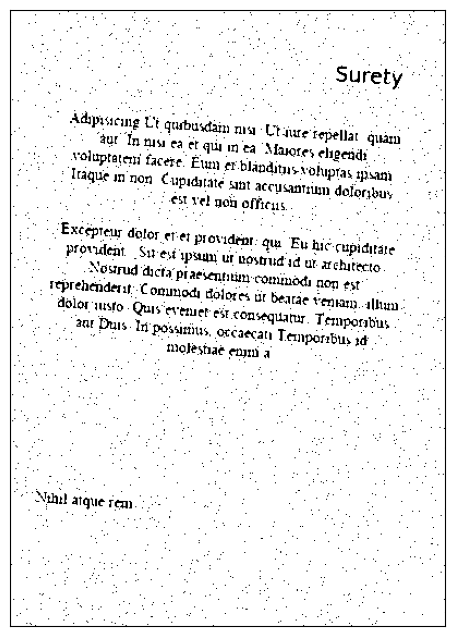

In [7]:
# generates random id and get it's image path and label path
id, sample_image_path, sample_label_path = get_random_img()

# displays image
display_image(path=sample_image_path)

# writes id and angle of sample in output
with open(sample_label_path) as f:
    angle = f.read()
print('ID of document is :', id)
print('Rotation angle is :', angle)

In [8]:
def display_image_grid(images, n=10, angles=None):
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(n, n),
                     axes_pad=0.25,
                     )

    i = 0
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])
        if angles is not None:
            angle = angles[i] - 5
            ax.set_title(label=str(angle))
        i += 1

    plt.show()

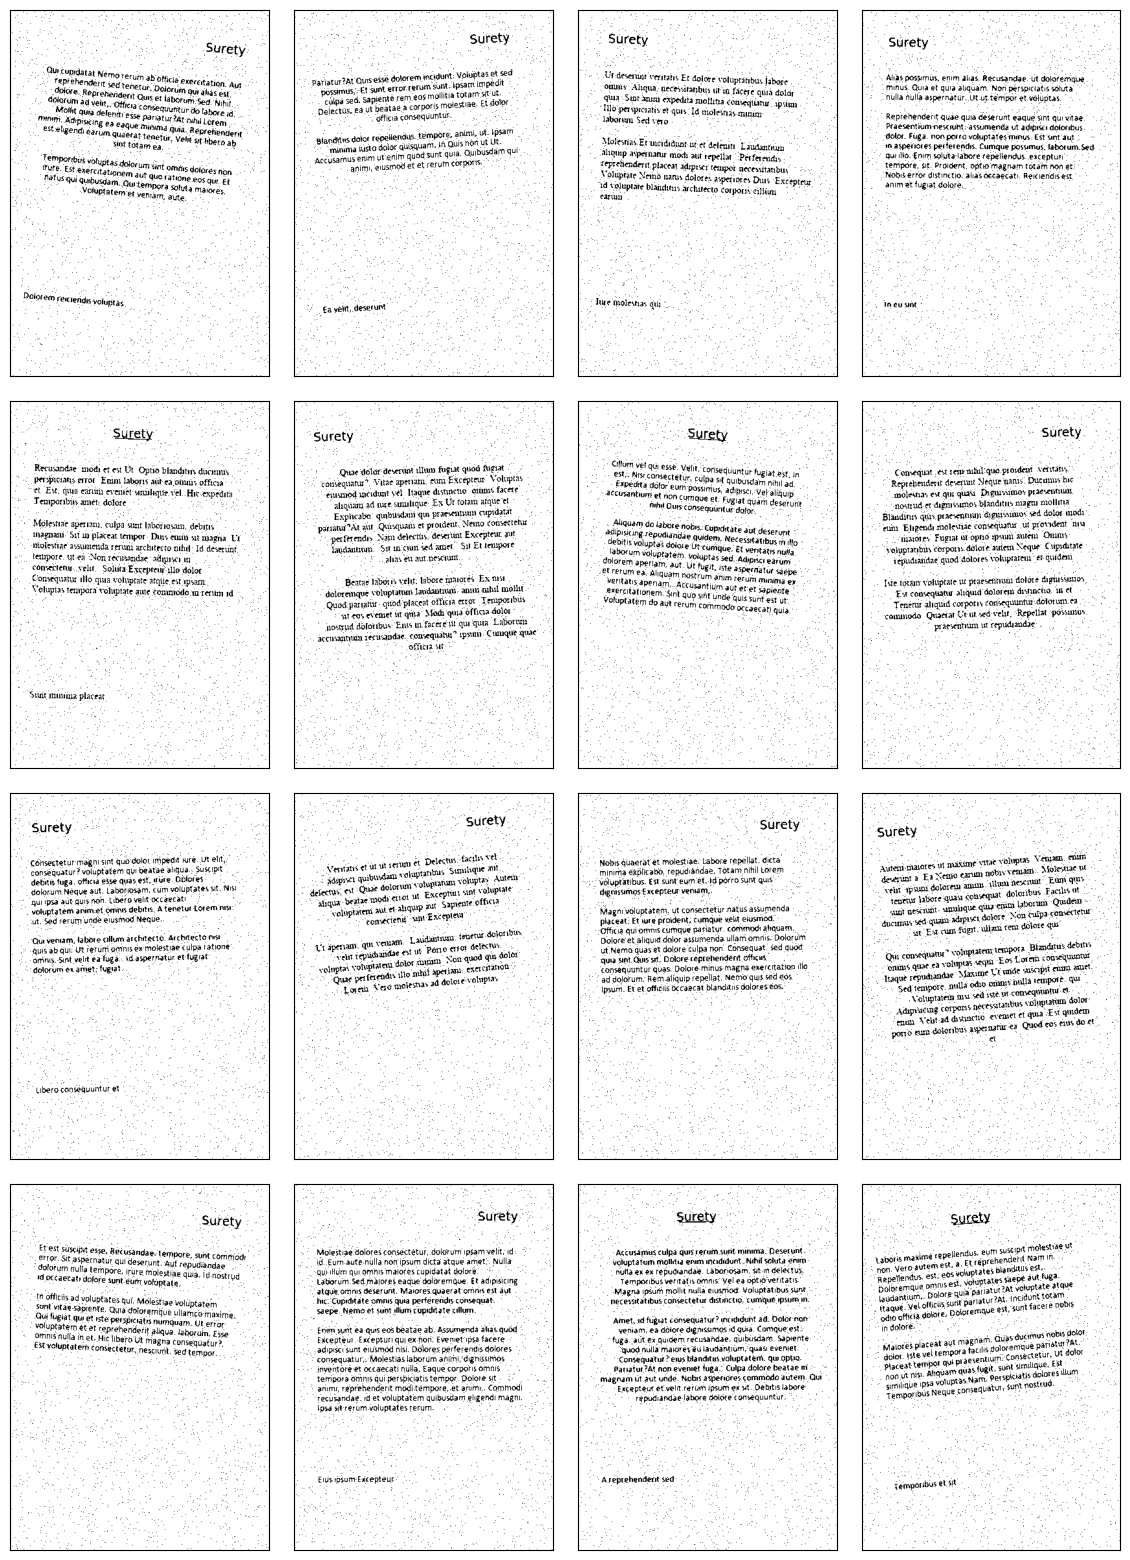

In [9]:
sampled_images = []
sampled_ids = []

for i in range(16):
    id, sample_image_path, sample_label_path = get_random_img()
    if id not in sampled_ids:
        img = Image.open(sample_image_path)
        sampled_ids.append(id)
        sampled_images.append(img)

display_image_grid(sampled_images, 4)

In [10]:
def denoise(img, to_PIL=True):
    img = denoise_tv_chambolle(img, weight=0.5)
    if to_PIL:
        Image.fromarray(img)
    return img

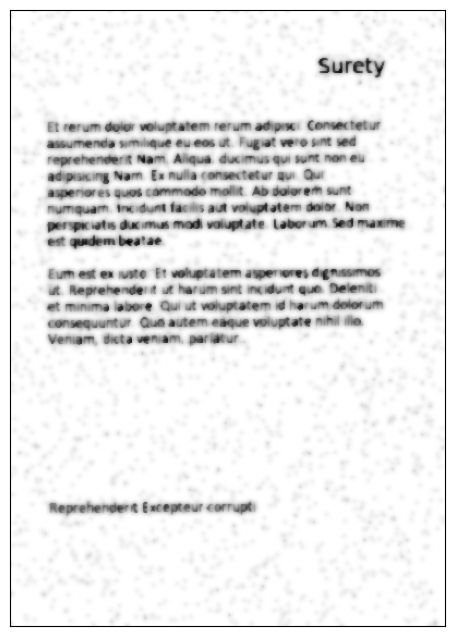

In [11]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)

img = denoise(img)
display_image(img=img)

In [12]:
def fft(img, to_PIL=True):
    f = cv2.dft(np.float32(img))    # Discrete Fourier transform
    fshift = np.fft.fftshift(f)     # Shift the zero-frequency component to the center of the spectrum
    f_abs = np.abs(fshift) + 1.0    # shift to ensure no zeroes are present in image array
    f_img = 20 * np.log(f_abs)      # final result
    if to_PIL:
        return Image.fromarray(f_img)
    return f_img

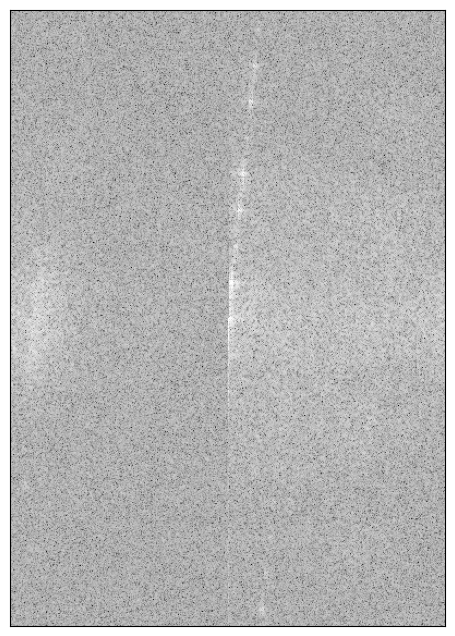

In [13]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)
# img = cv2.imread(sample_image_path)
# img = img[:,:,0]

f_img = fft(img)
display_image(img=f_img)

In [14]:
def preprocess(img):
    return fft(denoise(img))

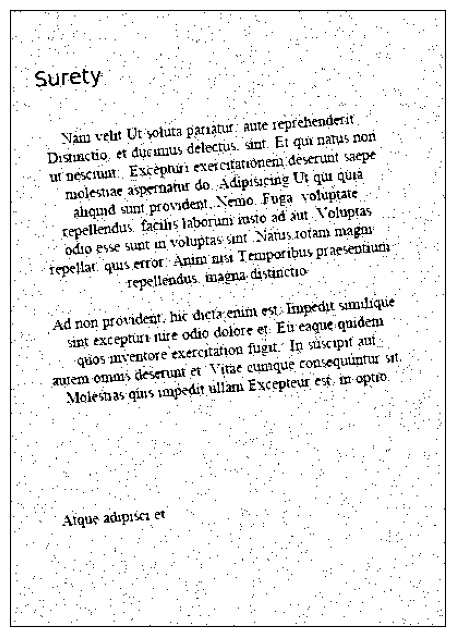

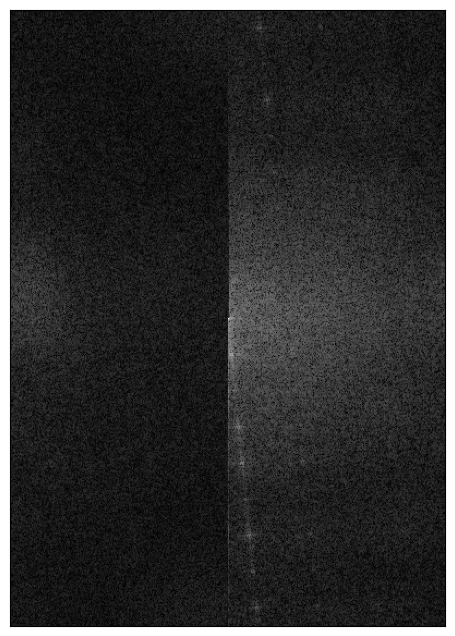

In [15]:
id, sample_image_path, sample_label_path = get_random_img()
img = cv2.imread(sample_image_path)
img = img[:,:,0]

f_img = preprocess(img)
display_image(img=img)
display_image(img=f_img)

После применения шумоподавления и быстрого преобразования Фурье (FFT), можно хорошо увидеть угол отклонения текста, применяем ко всем изображениям

In [16]:
prep_image_paths = os.path.join(root, 'preprocessed images')
os.mkdir(prep_image_paths)

for img_name in os.listdir(image_paths):
    img_src_path = os.path.join(image_paths, img_name)
    img = Image.open(img_src_path)
    img = np.array(img)
    img = preprocess(img)

    img = np.array(img)
    img = Image.fromarray((img).astype(np.uint8))
    img_dst_path = os.path.join(prep_image_paths, img_name)
    img.save(img_dst_path)

FileExistsError: [Errno 17] File exists: 'scan_doc_rotation 2/preprocessed images'

In [17]:
labels = {}
for textfile in label_list:
    path = os.path.join(label_paths, textfile)
    with open(path) as f:
        label = float(f.read())
    file_name = textfile.split('.')[0]
    labels[file_name] = round(label)

In [18]:
labels['scan_000'], labels['scan_010'], labels['scan_499']


(0, -3, -1)

In [19]:
df = pd.DataFrame(data={'name':labels.keys(), 'label':labels.values()})
df['categorical label'] = df['label'] + 5
df['categorical label'] = df['categorical label'].astype('int').astype('category')

In [20]:
df.head()


name  label categorical label
0  scan_000      0                 5
1  scan_001     -2                 3
2  scan_002     -5                 0
3  scan_003     -5                 0
4  scan_004     -1                 4

In [28]:

df_train, df_val = train_test_split(df, test_size=0.2)
df_train.shape, df_val.shape

((400, 3), (100, 3))

In [30]:
# Подготовка данных для линейной регрессии
train_images = [os.path.join(prep_image_paths, f'scan_{i:03}.png') for i in range(400)]
train_labels = [labels[f'scan_{i:03}'] for i in range(400)]

test_images = [os.path.join(prep_image_paths, f'scan_{i:03}.png') for i in range(400, 500)]
test_labels = [labels[f'scan_{i:03}'] for i in range(400, 500)]

# Преобразование изображений в векторы
def image_to_vector(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((128, 128))
    return np.array(img).flatten()

X_train = np.array([image_to_vector(img) for img in train_images])
y_train = np.array(train_labels)

X_test = np.array([image_to_vector(img) for img in test_images])
y_test = np.array(test_labels)

# Обучение модели линейной регрессии
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

# Оценка модели
y_pred_train = lin_reg_model.predict(X_train)
y_pred_test = lin_reg_model.predict(X_test)

mse_train = np.mean((y_train - y_pred_train) ** 2)
mse_test = np.mean((y_test - y_pred_test) ** 2)

r2_train = lin_reg_model.score(X_train, y_train)
r2_test = lin_reg_model.score(X_test, y_test)

print(f"Linear Regression - Train MSE: {mse_train}, Test MSE: {mse_test}")
print(f"Linear Regression - Train R²: {r2_train}, Test R²: {r2_test}")

Linear Regression - Train MSE: 6.010085025994799e-28, Test MSE: 0.12681970157426423
Linear Regression - Train R²: 1.0, Test R²: 0.9811829037963286


In [31]:
# Вывод предсказанных меток для тестовой выборки
print("Predicted labels for test set:", y_pred_test)

Predicted labels for test set: [-3.54923774  0.64727545 -3.29103032  0.93544024  4.26568242  3.8386855
  0.75141426  2.93757668  3.05161259  2.08157085 -4.01097297 -3.29943372
 -0.45722184  1.67429312  0.99954579 -0.0104402   3.1266301  -0.15933781
 -2.07314484  0.69332471 -2.01004296 -4.26047308  3.92737824  3.40165279
  4.33291408  2.19204886 -2.29854364  0.33402597 -1.52799843 -1.59594092
 -0.74544155 -1.22760119  1.34074705  3.34957692 -0.46526621 -3.97448162
  1.69126332 -1.73982749  1.67747307  1.20689746  3.9620523   2.51744031
  4.318627   -0.72863297  2.81419914  1.13502699  2.43685468  2.43974668
  1.2842421   2.84354821 -1.88719181 -4.72955753 -1.72590667  1.29237638
 -2.02429402 -4.39344783  3.18210694 -1.3452711  -0.32601521 -1.85129923
 -1.43993596 -4.31647363  0.43947733 -0.75284336 -1.97804493 -4.12794077
 -4.76131083 -2.19390692  0.21982911  1.0720887  -3.12976613  4.46445166
  1.8380755   1.41748742  0.66689656 -0.37489954  0.10364564  3.82540788
  1.76682942  1.51400

In [32]:
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, num_class=21):
        """
        Args:
            df (pd.DataFrame): DataFrame of image names and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.num_class = num_class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0] + '.png')
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = df.iloc[idx, 2]

        return image, int(label)

In [33]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0, std=1)
])

train_dataset = CustomDataset(df_train, prep_image_paths, transform)
val_dataset = CustomDataset(df_val, prep_image_paths, transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=64)

In [37]:
# Преобразование меток в категории
df['categorical label'] = df['label'] + 5
df['categorical label'] = df['categorical label'].astype('int')

# Обучение модели классификации
from sklearn.ensemble import RandomForestClassifier

clf_model = RandomForestClassifier(n_estimators=100)
clf_model.fit(X_train, df_train['categorical label'])

# Предсказание меток для тестовой выборки
y_pred_test_clf = clf_model.predict(X_test)

# Оценка модели на тренировочной выборке
y_pred_train_clf = clf_model.predict(X_train)

# Преобразование категориальных меток обратно в числовые
train_labels_numeric = df_train['categorical label'].astype('int')
val_labels_numeric = df_val['categorical label'].astype('int')

mse_train_clf = np.mean((train_labels_numeric - y_pred_train_clf) ** 2)
mse_test_clf = np.mean((val_labels_numeric - y_pred_test_clf) ** 2)

r2_train_clf = clf_model.score(X_train, train_labels_numeric)
r2_test_clf = clf_model.score(X_test, val_labels_numeric)

In [38]:
print(f"Classification Model - Train MSE: {mse_train_clf}")
print(f"Classification Model - Train R²: {r2_train_clf}")

Classification Model - Train MSE: 0.0
Classification Model - Train R²: 1.0


In [39]:
# Вывод предсказанных меток для тестовой выборки
print("Predicted labels for test set (classification):", y_pred_test_clf)

Predicted labels for test set (classification): [ 9  5  4  1  5  7  1  4  7  9  5  7  7  7  7  7  7  9  3  5  6  5  5  3
  5  7  7  3  7  1  7  1  7  1  3  5  5  1  1  5  7  9  6  8  9  5  8  6
  7  5  9  7  1  1  6  9  9  1  3  5  7  9  8  5  3  7  7  1  1  3  4  6
  7  5  1  7  6  6  7  5  9  3  5  9 10  6  7  8  7  7  9  8  0  2  7  4
  9  7  2  1]


Используем сверточную нейронную сеть RotNet. Она предназначена для прогнозирования угла поворота (классификации) изображений.

In [41]:
class RotNet(nn.Module):
    def __init__(self, num_classes=2, num_channels=1, in_channels=1, has_dropout=True, dropout_rate=0.25):
        super(RotNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Residual Blocks
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.max_pool = nn.MaxPool2d((2, 2))

        # MLP
        self.fc_1 = nn.Linear(12544, 128)
        self.fc_2 = nn.Linear(128, self.num_classes)

        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = x.view(x.shape[0], -1)
        x = self.fc_1(x)
        x = self.ReLU(x)
        x = self.dropout(x)

        x = self.fc_2(x)
        x = self.softmax(x)
        return x

In [42]:
model = RotNet(num_classes=11, has_dropout=True)
summary.summary(model, (1, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
              ReLU-5           [-1, 32, 61, 61]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Dropout-10           [-1, 64, 14, 14]               0
           Linear-11                  [-1, 128]       1,605,760
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [43]:
model = RotNet(num_classes=11)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [44]:
random_input = torch.rand((1, 1, 128, 128))
output = model(random_input)
output, torch.sum(output)

(tensor([[0.0882, 0.0842, 0.0941, 0.0902, 0.0856, 0.0879, 0.0882, 0.0977, 0.0872,
          0.0983, 0.0984]], grad_fn=<SoftmaxBackward0>),
 tensor(1., grad_fn=<SumBackward0>))

In [45]:
trian_loss = {}
val_loss = {}

start_time = time.time()
for epoch in range(50):
    train_losses = []
    val_losses = []
    running_loss = 0
    count = 0
    for i, inp in enumerate(train_loader):
        inputs = inp[0]
        inputs = inputs
        labels = inp[1]
        labels = labels
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count += 1

    if epoch%5 == 0:
        for i, inp in enumerate(val_loader):
            inputs = inp[0]
            inputs = inputs
            labels = inp[1]
            labels = labels
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

        trian_loss[epoch] = np.mean(train_losses)
        val_loss[epoch] = np.mean(val_losses)
        print('Epcoh', epoch, ': train loss =', np.mean(train_losses), ', val loss =', np.mean(val_losses))

end_time = time.time()
print('Training Done in', end_time - start_time, 'seconds')

Epcoh 0 : train loss = 2.4006694725581577 , val loss = 2.3969433307647705
Epcoh 5 : train loss = 2.3931390898568288 , val loss = 2.3938952684402466
Epcoh 10 : train loss = 2.3901595728737965 , val loss = 2.3914027214050293
Epcoh 15 : train loss = 2.3894971779414584 , val loss = 2.3913885354995728
Epcoh 20 : train loss = 2.3884264060429166 , val loss = 2.389242172241211
Epcoh 25 : train loss = 2.3863680022103444 , val loss = 2.3919239044189453
Epcoh 30 : train loss = 2.383016790662493 , val loss = 2.395832657814026
Epcoh 35 : train loss = 2.3910153933933804 , val loss = 2.39182710647583
Epcoh 40 : train loss = 2.3871733120509555 , val loss = 2.396793484687805
Epcoh 45 : train loss = 2.392259427479335 , val loss = 2.391679883003235
Training Done in 918.1562039852142 seconds


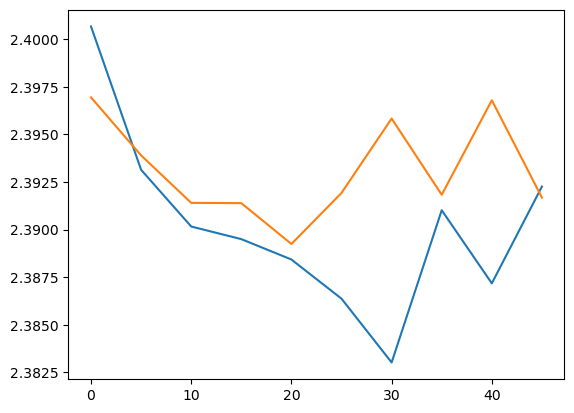

In [46]:
plt.plot(list(trian_loss.keys()), list(trian_loss.values()))
plt.plot(list(val_loss.keys()), list(val_loss.values()))

In [48]:
correct_train = 0
total_train = 0

correct_val = 0
total_val = 0

val_output = []

with torch.no_grad():
    for data in train_loader:
        tensor = data[0]
        tensor = tensor
        label = data[1]
        label = label
        outputs = model(tensor)

        _, predicted = torch.max(outputs.data, 1)
        total_train += tensor.size(0)
        correct_train += (predicted == label).sum().item()

    for data in val_loader:
        tensor = data[0]
        tensor = tensor
        label = data[1]
        label = label
        outputs = model(tensor)

        _, predicted = torch.max(outputs.data, 1)
        val_output.append(predicted)
        total_val += tensor.size(0)
        correct_val += (predicted == label).sum().item()


In [49]:
print('Accuracy on Train Data :', 100*(correct_train/total_train), '%')
print('Accuracy on Validation Data :', 100*(correct_val/total_val), '%')

Accuracy on Train Data : 11.5 %
Accuracy on Validation Data : 4.0 %


In [57]:
# Оценка модели на тренировочной выборке
model.eval()
train_predictions = []
train_labels_list = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions.extend(predicted.tolist())
        train_labels_list.extend(labels.tolist())

# Преобразование списков в numpy массивы
train_predictions = np.array(train_predictions)
train_labels_list = np.array(train_labels_list)

# Вычисление MSE и R² для тренировочной выборки
mse_train_cnn = np.mean((train_labels_list - train_predictions) ** 2)
r2_train_cnn = 1 - (np.sum((train_labels_list - train_predictions) ** 2) / np.sum((train_labels_list - np.mean(train_labels_list)) ** 2))

print(f"ConvNet - Train MSE: {mse_train_cnn}")
print(f"ConvNet - Train R²: {r2_train_cnn}")

# Предсказание меток для тестовой выборки
test_predictions = []
for inputs in val_loader:
    outputs = model(inputs[0])
    _, predicted = torch.max(outputs.data, 1)
    test_predictions.extend(predicted.tolist())

# Вывод предсказанных меток для тестовой выборки
print("Predicted labels for test set (ConvNet):", test_predictions)

ConvNet - Train MSE: 25.7425
ConvNet - Train R²: -1.776371586747457
Predicted labels for test set (ConvNet): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [51]:
test_df = pd.DataFrame(data={'image':list(map(lambda x:x.split('.')[0], test_list)), 'label':np.zeros(len(test_list), int)})
dataset_test = CustomDataset(test_df, prep_image_paths, transform)
test_loader = DataLoader(dataset_test, batch_size=100)

In [52]:
for i, inp in enumerate(test_loader):
    inputs = inp[0]
    inputs = inputs
    labels = inp[1]
    labels = labels.float()
    optimizer.zero_grad()

    outputs = model(inputs)
outputs = outputs.cpu().detach().numpy()

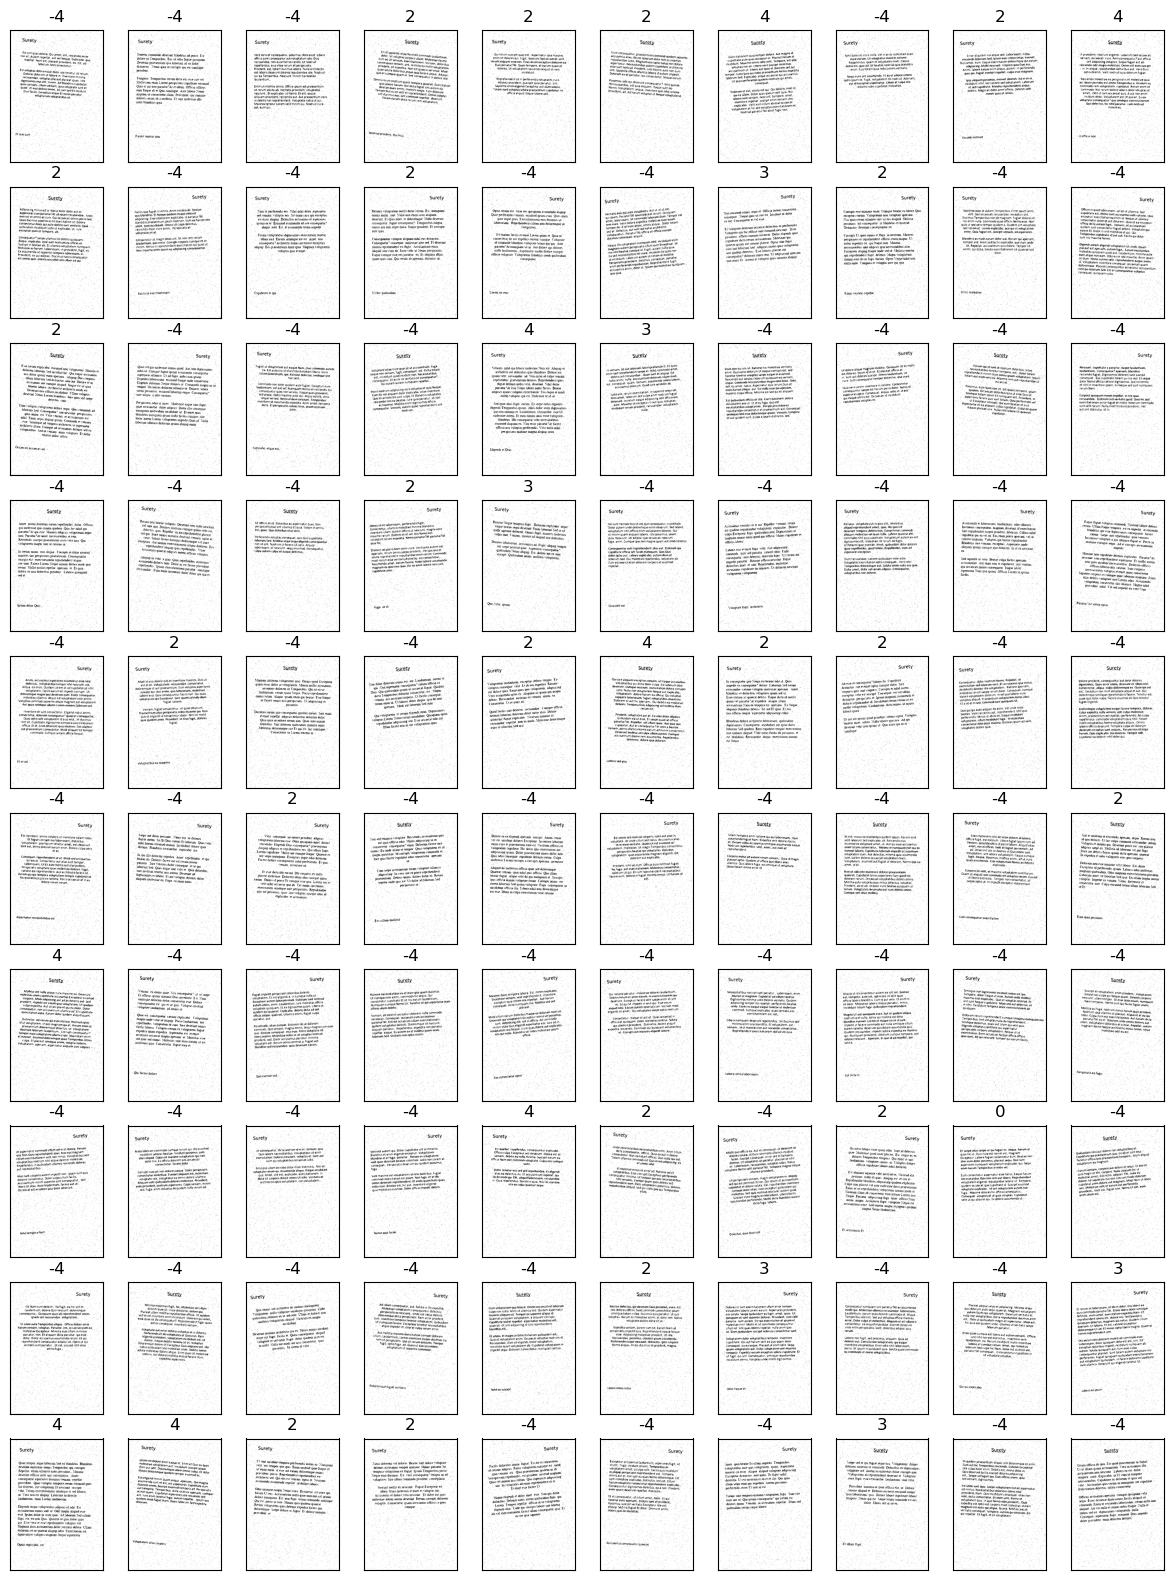

In [53]:
predicted_labels = np.argmax(outputs, axis=1)

test_images = []
for image_name in test_df['image'].values:
    image_path = os.path.join(image_paths, image_name+'.png')
    img = Image.open(image_path)
    test_images.append(img)

display_image_grid(test_images, 10, predicted_labels)